# Elmy 1.02 (rev 28/06/2023)
### scritto da Di Cecco Antonio
* #### per uso personale e non ridistribuibile in forma commerciale
* #### https://creativecommons.org/licenses/by-nc-nd/2.5/it/

## Librerie

In [1]:
!pip install yfinance

## Modello

[*********************100%***********************]  1 of 1 completed


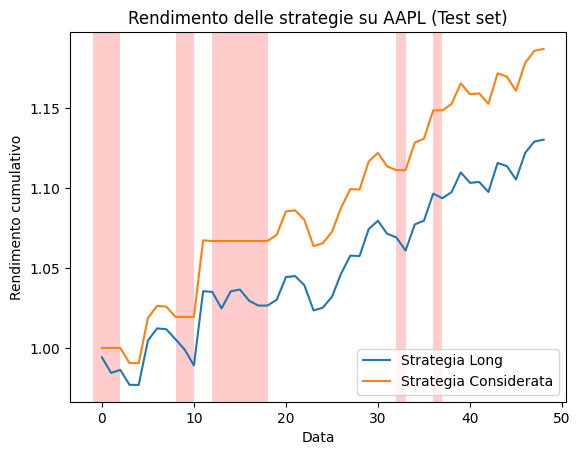

In [146]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def create_features(data, window=7):
    data = data.copy()  # Creo una copia del DataFrame per evitare il warning
    for what in ['Close','High','Low']:
            data['Close_ROC'] = data['Close'].pct_change()
            data[what+'_ROC_Min'] = data[what].pct_change().rolling(window=window).min()
            data[what+'_ROC_Max'] = data[what].pct_change().rolling(window=window).max()
            data[what+'_ROC_Median'] = data[what].pct_change().rolling(window=window).median()

    return data.dropna()

def train_ELM_plus(X_train, y_train, num_hidden=40, lam=1e-2):
    class ELM_plus:
        def __init__(self, num_hidden):
            self.num_hidden = num_hidden

        def _relu(self, x):
            return np.where(x > 0, x, 0)

        def _hidden_output(self, X):
            hidden_output = np.zeros((X.shape[0], self.num_hidden))
            for i in range(self.num_hidden):
                hidden_output[:, i] = self._relu( X @ self.input_weights[:, i])
            return hidden_output

        def train(self, X_train, y_train):
            self.lin_reg = LinearRegression()
            self.lin_reg.fit(X_train, y_train)
            adjusted_targets = y_train - 0.5 * self.lin_reg.predict(X_train)

            self.input_weights = np.random.uniform(-1, 1, (X_train.shape[1], self.num_hidden))
            hidden_output = self._hidden_output(X_train)
            identity_matrix = np.eye(hidden_output.shape[1]) * lam
            self.output_weights = np.linalg.inv(hidden_output.T @ hidden_output + identity_matrix) @ hidden_output.T @ adjusted_targets

        def predict(self, X):
            elm_output = self._hidden_output(X) @ self.output_weights
            return elm_output + 0.5 * self.lin_reg.predict(X)

    model = ELM_plus(num_hidden=num_hidden)
    model.train(X_train, y_train)
    return model




# Scarica i dati finanziari di Apple
ticker= 'AAPL'
apple = yf.download(ticker, period='1y')

# Seleziona solo le colonne necessarie
data = apple[['Close', 'High', 'Low']]

# Crea le features
data = create_features(data)
data=data.drop(columns=['High','Low','Close'])

X = data[:-1].values
y = data['Close_ROC'][1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)


#from sklearn.feature_selection import SelectKBest, f_regression
#num_features = 10
#selector = SelectKBest(f_regression, k=num_features)
#X_train_selected = selector.fit_transform(X_train, y_train)


best_model = None
best_corr = -1  # Inizializzo con un valore negativo per identificare il miglior modello
for _ in range(20):
    model = train_ELM_plus(X_train, y_train)
    y_pred = model.predict(X_train)
    correlation = np.corrcoef(y_train, y_pred)[0, 1]

    if correlation > best_corr:
        best_corr = correlation
        best_model = model


test_data = pd.DataFrame()
test_data['Predicted_ROC'] = best_model.predict(X_test)
test_data['Long_Return'] = (1 + y_test).cumprod()
test_data['Cumulative_Return_Strategy'] = np.where(test_data['Predicted_ROC'] > 0, 1 + y_test, 1).cumprod()



# Creazione del grafico
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.plot(test_data['Long_Return'], label='Strategia Long')
ax.plot(test_data['Cumulative_Return_Strategy'], label='Strategia Considerata')

x_start = test_data.index[0] - 1

for i in range(len(test_data)):
    if test_data['Predicted_ROC'].iloc[i] < 0:
        ax.axvspan(x_start, x_start + 1, facecolor='red', alpha=0.2)
    x_start += 1

# Personalizzazione dell'aspetto del grafico
ax.set_xlabel('Data')
ax.set_ylabel('Rendimento cumulativo')
ax.set_title(f'Rendimento delle strategie su {ticker} (Test set)')
ax.legend()

# Mostrare il grafico
plt.show()

In [87]:
data

,Close,High,Low,Close_ROC,Close_ROC_Min,Close_ROC_Max,Close_ROC_Median,High_ROC_Min,High_ROC_Max,High_ROC_Median,Low_ROC_Min,Low_ROC_Max,Low_ROC_Median
Date,,,,,,,,,,,,,
2022-07-11,144.869995,146.639999,143.779999,-0.014758,-0.018028,0.023999,0.009607,-0.016350,0.018484,0.006824,-0.021219,0.030308,0.012004
2022-07-12,145.860001,148.449997,145.050003,0.006834,-0.014758,0.023999,0.009607,-0.006167,0.018484,0.012343,-0.008414,0.030308,0.012004
2022-07-13,145.490005,146.449997,142.119995,-0.002537,-0.014758,0.023999,0.006834,-0.013473,0.018484,0.012343,-0.020200,0.030308,0.009362
2022-07-14,148.470001,148.949997,143.250000,0.020482,-0.014758,0.023999,0.006834,-0.013473,0.017725,0.012343,-0.020200,0.030308,0.008833
2022-07-15,150.169998,150.860001,148.199997,0.011450,-0.014758,0.023999,0.006834,-0.013473,0.017071,0.012343,-0.020200,0.034555,0.008833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,186.679993,187.559998,185.009995,-0.001711,-0.005860,0.016525,0.000487,-0.004760,0.011552,0.002520,-0.009869,0.009669,0.002666
2023-06-26,185.270004,188.050003,185.229996,-0.007553,-0.007553,0.016525,-0.001711,-0.004760,0.011552,0.002613,-0.009869,0.009669,0.002666
2023-06-27,188.059998,188.389999,185.669998,0.015059,-0.007553,0.016525,-0.001711,-0.004760,0.008845,0.002520,-0.009869,0.007296,0.002375
